In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True,)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
#1. Data Preparation
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

# Normalize pixel values (0-255 -> 0-1)
X = X / 255.0

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Loading MNIST dataset...
Train shape: (49000, 784), Test shape: (21000, 784)


In [4]:
# 2. Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs", multi_class="multinomial", random_state=42),
    "SVM": SVC(kernel="rbf", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

In [5]:
# 3. Train & Evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=3))
    
    results[name] = {
        "model": model,
        "accuracy": acc,
        "train_time": train_time,
        "y_pred": y_pred
    }


Training Logistic Regression...


C:\Users\bbuser\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9194
              precision    recall  f1-score   support

           0      0.947     0.971     0.959      2071
           1      0.953     0.973     0.963      2363
           2      0.913     0.904     0.908      2097
           3      0.894     0.890     0.892      2142
           4      0.925     0.914     0.919      2047
           5      0.885     0.870     0.877      1894
           6      0.943     0.954     0.949      2063
           7      0.932     0.938     0.935      2188
           8      0.893     0.876     0.884      2048
           9      0.897     0.892     0.895      2087

    accuracy                          0.919     21000
   macro avg      0.918     0.918     0.918     21000
weighted avg      0.919     0.919     0.919     21000


Training SVM...
SVM Accuracy: 0.9768
              precision    recall  f1-score   support

           0      0.982     0.993     0.987      2071
           1      0.985     0.989     0.987      2363
   

C:\Users\bbuser\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:26:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9749
              precision    recall  f1-score   support

           0      0.979     0.989     0.984      2071
           1      0.985     0.989     0.987      2363
           2      0.975     0.975     0.975      2097
           3      0.978     0.975     0.976      2142
           4      0.977     0.962     0.969      2047
           5      0.981     0.966     0.973      1894
           6      0.973     0.985     0.979      2063
           7      0.976     0.977     0.977      2188
           8      0.967     0.969     0.968      2048
           9      0.956     0.960     0.958      2087

    accuracy                          0.975     21000
   macro avg      0.975     0.975     0.975     21000
weighted avg      0.975     0.975     0.975     21000



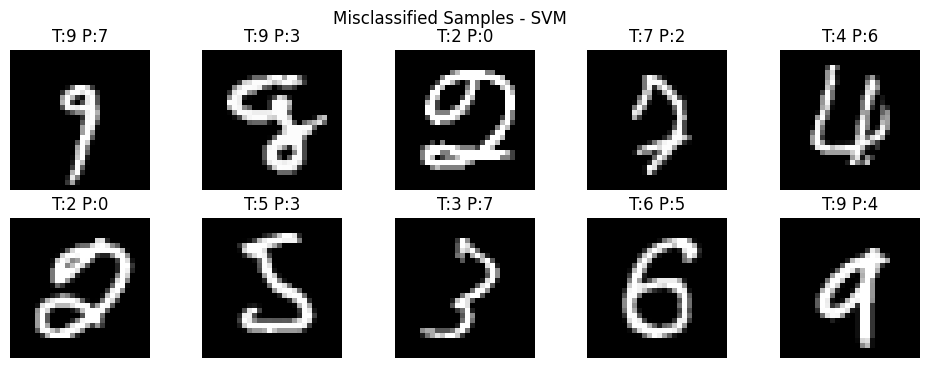

In [6]:
# 4. Error Analysis
def plot_misclassified(model_name, X_test, y_test, y_pred, n=10):
    misclassified_idx = np.where(y_test != y_pred)[0]
    sample_idx = np.random.choice(misclassified_idx, n, replace=False)
    
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(sample_idx):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap="gray")
        plt.title(f"T:{y_test[idx]} P:{y_pred[idx]}")
        plt.axis("off")
    plt.suptitle(f"Misclassified Samples - {model_name}")
    plt.show()

# show misclassified samples for SVM
plot_misclassified("SVM", X_test, y_test, results["SVM"]["y_pred"])

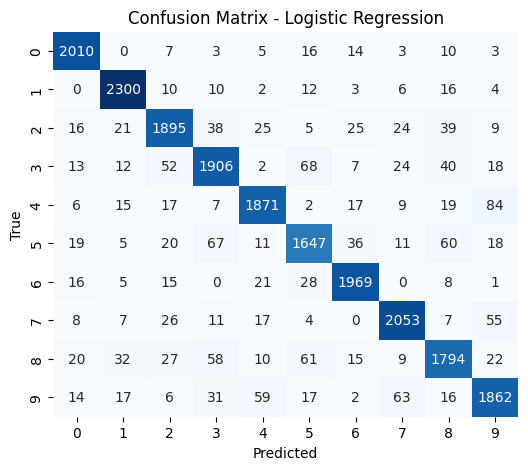

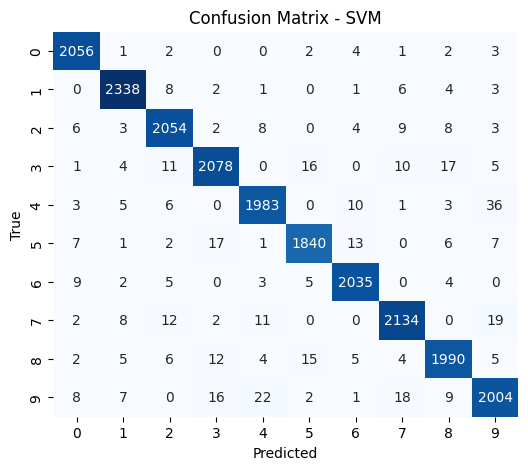

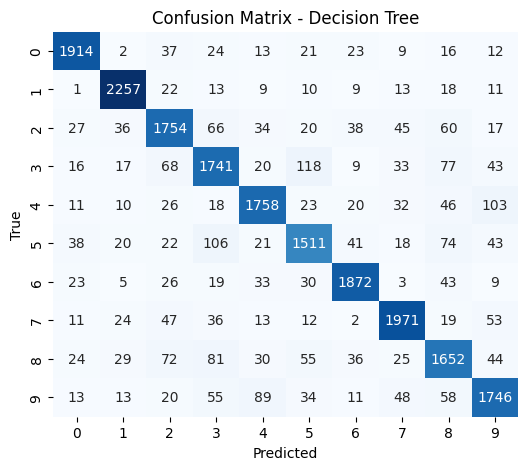

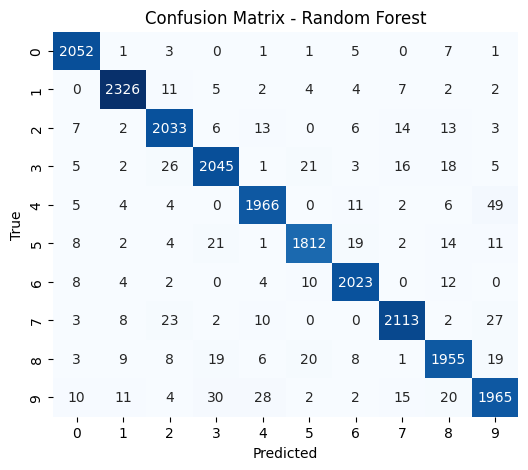

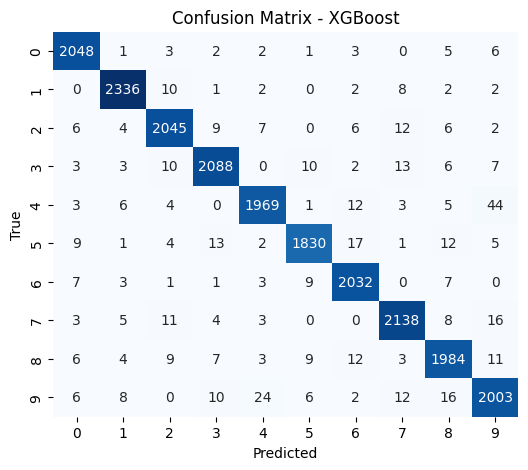

In [7]:
# 5. Confusion Matrices
for name, res in results.items():
    cm = confusion_matrix(y_test, res["y_pred"])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # <-- added annot=True, fmt="d"
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

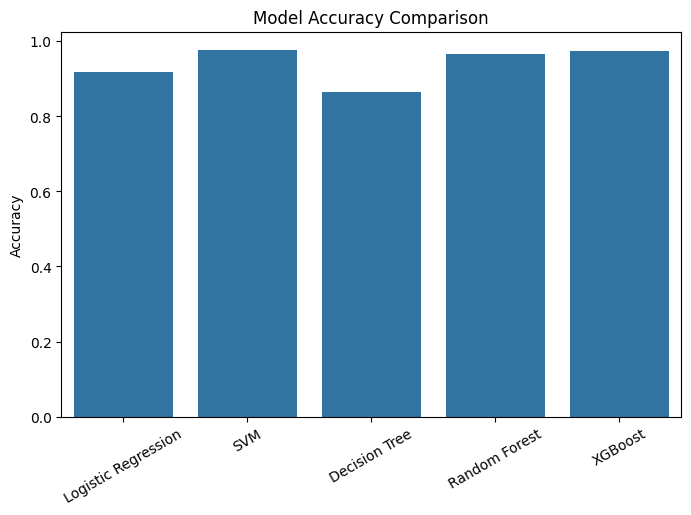

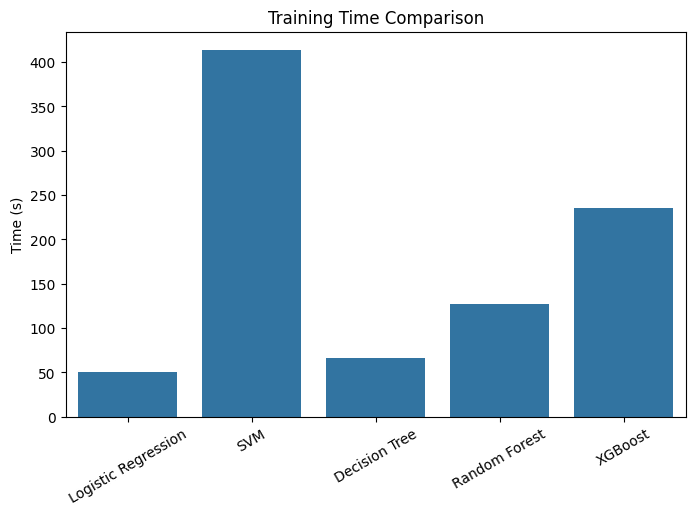

In [8]:
# 6. Summary Comparison
model_names = list(results.keys())
accuracies = [res["accuracy"] for res in results.values()]
times = [res["train_time"] for res in results.values()]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=times)
plt.title("Training Time Comparison")
plt.ylabel("Time (s)")
plt.xticks(rotation=30)
plt.show()